In [1]:
import numpy as np
import matplotlib.pyplot as plt

import collections
import os
import copy
import logging
import pickle
import time
from tqdm import tqdm
import math
import itertools
import scipy.optimize as optimize
import pandas as pd

/home/wei/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#cost = np.random.rand(3,5)
cost = np.random.uniform(0,1,3*5).reshape(3,5)
print(cost)
#power = np.random.rand(3,5,2)*0.5
power = np.random.uniform(0,0.5,30).reshape(3,5,2)
lam = np.array([2, 3, 5])
B = np.random.rand(5,2)*2
print("beat", B*5)
B = np.tile(B,3).reshape((5,2,3))
saro = np.random.rand(3,5).repeat(2).reshape(3,5,2)/power
#A = np.where(power <= 0.1, np.random.rand(3,5).repeat(2).reshape(3,5,2)/power, 0)
#print("saro",A)
#print(power)

# print(B)
# print(np.transpose(power, (1, 2, 0)))
# print("divide:", np.transpose(power, (1, 2, 0))/B)
# print("lalala",np.transpose(power, (1, 2, 0))/B*np.tile(np.tile(lam,5).reshape((5, 3)),2).reshape(5,2,3))
# print(cost,power,lam)
# print(np.ravel(cost.T*np.tile(lam,5).reshape((5, 3))))
c = np.ravel(cost.T*np.tile(lam,5).reshape((5, 3)))
print("beat", B)
a = np.transpose(power, (1, 2, 0))/B*np.tile(np.tile(lam,5).reshape((5, 3)),2).reshape(5,2,3)
print("ssss",lam.repeat(5))
print(lam.repeat(10).reshape(3,5,2))
print("1111", (power/lam.repeat(10).reshape(3,5,2)))

identity_matrix = np.eye(5)
stra_init = np.tile(identity_matrix[1,:],3)
print(stra_init)
print("c",c)
print("obj", np.sum(c* np.ravel(stra_init)))

print(a +0.1)
A_ub = np.zeros((5*2,len(c)))
count = 0
j = 0
for i in range(5):
    for m in range(2):
        for k in range(3):
            A_ub[j,count+k] = a[i,m,k]
        j += 1
    count += 3
B_ub = np.ones(5*2)
A_eq = np.tile(np.eye(3),5)
print(A_eq)
B_eq = np.ones(3)
print(B_eq)
LP_solution = optimize.linprog( c.T, A_ub, B_ub.T, A_eq, B_eq.T)
print(LP_solution.message)
print("sssss",LP_solution.x)
optimal_allocation = LP_solution.x
print("qqq",optimal_allocation.reshape(5,3))
a= optimal_allocation.reshape(5,3)
print(a[:,0])
print(np.random.uniform(0,1,3))
m = np.random.uniform(0.5,1,3*5).reshape(3,5)
print(m[2,4])
print(np.power(2,np.round(np.log2(50))))

[[0.99470887 0.14967405 0.56637714 0.88510036 0.36344364]
 [0.68754654 0.73410728 0.24775453 0.76511076 0.73050785]
 [0.3718641  0.6109153  0.88938439 0.07508339 0.98310001]]
beat [[1.65168197 1.50679946]
 [8.48883661 6.79834327]
 [3.75801414 3.87108182]
 [1.74945738 5.59078339]
 [5.74655784 4.86482011]]
beat [[[0.33033639 0.30135989 0.33033639]
  [0.30135989 0.33033639 0.30135989]]

 [[1.69776732 1.35966865 1.69776732]
  [1.35966865 1.69776732 1.35966865]]

 [[0.75160283 0.77421636 0.75160283]
  [0.77421636 0.75160283 0.77421636]]

 [[0.34989148 1.11815668 0.34989148]
  [1.11815668 0.34989148 1.11815668]]

 [[1.14931157 0.97296402 1.14931157]
  [0.97296402 1.14931157 0.97296402]]]
ssss [2 2 2 2 2 3 3 3 3 3 5 5 5 5 5]
[[[2 2]
  [2 2]
  [2 2]
  [2 2]
  [2 2]]

 [[3 3]
  [3 3]
  [3 3]
  [3 3]
  [3 3]]

 [[5 5]
  [5 5]
  [5 5]
  [5 5]
  [5 5]]]
1111 [[[0.0907828  0.02746594]
  [0.03093581 0.04874727]
  [0.0327337  0.13312564]
  [0.00924889 0.20766765]
  [0.10294009 0.15937598]]

 [[0.0623

In [6]:
class VNE:
    def __init__(self, total_power, K, M, T, lam, power, beta):
        self.T = T

        self.M = M

        self.K = K

        self.t = 0
        
        self.pho = 1.05
        
        self.power = power
        
        self.total_power = total_power
        
        self.lam = lam

        self.beta = beta

        self.pulls = np.zeros((self.M, self.K),  dtype=np.int32)
        
        self.total_power_cumu = np.zeros((self.M, self.K))
        
        self.power_cumu = np.zeros_like(self.power)
        
        self.power_con_cumu= np.zeros_like(self.power)
                
        self.lam_cumu = np.zeros(self.M)
        
        self.total_power_hat = np.zeros((self.M, self.K))
        
        self.power_hat = np.zeros_like(self.power)
        
        self.lam_hat = np.zeros(self.M)
        
        self.update_times = np.unique([self.K*self.M+np.round(np.power( self.pho,k)) for k in np.arange(np.ceil(np.log(self.T)/np.log(self.pho)))])
        #print(self.update_times)
        self.kl_power = np.zeros_like(self.power)
        
        self.kl_total_power = np.zeros((self.M, self.K))
        
        self.kl_lam_up = np.zeros(self.M)
        
        self.kl_lam_dn = np.zeros(self.M)
        
        self.beta_new = np.tile(self.beta,self.M).reshape((self.K,np.shape(power)[-1],self.M))
        
    def KL(self, p, q):
        if p == 0:
            return math.log(1 / (1 - q))
        if p == 1:
            if q == 0:
                return 1e6
            return math.log(1 / q)
        return p * math.log(p / q) + (1 - p) * math.log((1 - p) / (1 - q))
    
    # First derivative of KL divergence w.r.t q
    def kl_prime(self, p, q):
        return -p / q + (1 - p) / (1 - q)
    
    def getUCBKL(self, estimated, sample_times,lb,ub,tol = 1e-7):
        if sample_times == 0:
            kl = ub
        else:
            bound = (math.log(self.t)) / sample_times 
            if estimated == ub:
                kl = ub
            else:
                q = (ub+estimated)/2
                while self.KL(estimated, q) < bound: 
                    q= (q+ub)/2
                #print("starting", q)
                compute_kl = self.KL(estimated, q)
                while np.abs(compute_kl -  bound) > tol:
                    #print("q",q)
                    compute_kl = self.KL(estimated, q)
                    #print("kl",compute_kl)
                    #print("bound",bound)
                    compute_kl_prime = self.kl_prime(estimated, q)
                    q -= (compute_kl-bound)/compute_kl_prime
                    #q = min(max(q,estimated),ub)
                    #if q == ub:
                    #    break
                kl = q
        return kl
    
    def getLCBKL(self, estimated, sample_times,lb,ub ,tol = 1e-7):
        if sample_times == 0:
            kl = lb
        else:
            bound = (math.log(self.t)) / sample_times 
            if estimated == 0:
                kl = lb
            else:
                q = (lb+estimated)/2
                while self.KL(estimated, q) < bound: 
                    q = (q+lb)/2
                compute_kl = self.KL(estimated, q)
                while np.abs(compute_kl -  bound) > tol:
                    compute_kl = self.KL(estimated, q)
                    compute_kl_prime = self.kl_prime(estimated, q)
                    q -= (compute_kl-bound)/compute_kl_prime
                kl = q
        return kl
    
    def compute_power(self, stra, opt_stra): 
        #print("cost",np.sum(np.ravel(self.total_power_cumu.T)))
#         for m in range(self.M):
#             if lam_t[m] > 0:
#                 return self.total_power_cumu[m,arms_t[m]]/self.pulls[m,arms_t[m]]
#             else:
#                 return 0
#        return np.sum(np.ravel(self.total_power.T*np.tile(self.lam,self.K).reshape((self.K, self.M))) * np.ravel(stra.T))
        #print((np.tile(self.lam,self.K).reshape((self.K, self.M))).T)
#        print("stra", stra)
#        print("opt",opt_stra)
#        print("minus", stra-opt_stra)
#        print("optstra", np.sum((stra-opt_stra)*np.tile(self.lam,self.K).reshape((self.K, self.M)).T*self.total_power))
        #print("objc", np.sum((stra- opt_stra)*(np.tile(self.lam,self.K).reshape((self.K, self.M))).T@self.total_power.T))
#        print ("wrong",np.sum((stra- opt_stra)*(np.tile(self.lam,self.K).reshape((self.K, self.M))).T*self.total_power)/np.sum(opt_stra*((np.tile(self.lam,self.K).reshape((self.K, self.M))).T)*self.total_power))
#        return np.sum(np.ravel(self.total_power_cumu.T))/ self.t
#        print("performance",np.sum(np.ravel(self.total_power.T*np.tile(self.lam,self.K).reshape((self.K, self.M))) * np.ravel((stra-opt_stra).T)) / np.sum(np.ravel(self.total_power.T*np.tile(self.lam,self.K).reshape((self.K, self.M))) * np.ravel(opt_stra.T)))

        return np.sum(np.ravel(self.total_power.T*np.tile(self.lam,self.K).reshape((self.K, self.M))) * np.ravel((stra-opt_stra).T)) / np.sum(np.ravel(self.total_power.T*np.tile(self.lam,self.K).reshape((self.K, self.M))) * np.ravel(opt_stra.T))


    
    def compute_utilization(self, arms_t):
        utilization = np.zeros((self.K, np.shape(self.power)[-1]))
        for arms in arms_t:
            for k in range(np.shape(self.power)[-1]):
                utilization[arms, k] = np.sum(self.power_con_cumu[:, arms, k])/(self.beta[arms, k]*self.t)
        return np.max(utilization)
    
    def enter(self):
        lam = np.zeros(self.M)
        player = np.random.choice(self.M, 1, p=self.lam)
        lam[player] = 1
        return lam.astype(int)
    
    def draw(self, arms, lam):
        total_power = np.zeros((self.M, self.K))
        power = np.zeros_like(self.power)
        for player in range(self.M):
            if lam[player] != 0:
                total_power[player][arms[player]] = np.random.binomial(1,self.total_power[player][arms[player]])
                for a in range(self.K):
                    for k in range(np.shape(self.power)[-1]):
                        power[player,a,k] = np.random.binomial(1,self.power[player,a,k])
        return total_power, power

    def lp(self, total_power, power, lam_dn):
        obj_mul = np.ravel(total_power.T*np.tile(lam_dn,self.K).reshape((self.K, self.M)))
        a = np.transpose(power, (1, 2, 0))/self.beta_new
        A_ub = np.zeros((self.K*np.shape(power)[-1],len(obj_mul)))
        count = 0
        j = 0
        for i in range(self.K):
            for m in range(np.shape(power)[-1]):
                for k in range(self.M):
                    A_ub[j,count+k] = a[i,m,k]
                j += 1
            count += self.M
        B_ub = np.ones(self.K*np.shape(power)[-1])
        A_eq = np.tile(np.eye(self.M),self.K)
        B_eq = np.ones(self.M)
        LP_solution = optimize.linprog( obj_mul.T, A_ub, B_ub.T, A_eq, B_eq.T)
        #print("our_algo_value", obj_mul.T @LP_solution.x)
        #print("our_algo_constraints", np.max(A_ub @LP_solution.x- B_ub))
        #LP_solution = optimize.linprog( obj_mul.T, A_ub, B_ub.T, A_eq, B_eq.T, options={'tol': 1e-12})
        return LP_solution.x, LP_solution.fun
    
    def lp_acc3(self, stra_init, total_power, power, lam_dn):
        obj_mul = np.ravel(total_power.T*np.tile(lam_dn,self.K).reshape((self.K, self.M)))
        a = np.transpose(power, (1, 2, 0))/self.beta_new
        A_ub = np.zeros((self.K*np.shape(power)[-1],len(obj_mul)))
        count = 0
        j = 0
        for i in range(self.K):
            for m in range(np.shape(power)[-1]):
                for k in range(self.M):
                    A_ub[j,count+k] = a[i,m,k]
                j += 1
            count += self.M
        B_ub = np.ones(self.K*np.shape(power)[-1])
        A_eq = np.tile(np.eye(self.M),self.K)
        B_eq = np.ones(self.M)
        LP_solution = optimize.linprog( obj_mul.T, A_ub, B_ub.T, A_eq, B_eq.T, x0 = stra_init)
        #LP_solution = optimize.linprog( obj_mul.T, A_ub, B_ub.T, A_eq, B_eq.T, options={'tol': 1e-12})
        return LP_solution.x, LP_solution.fun
    
    def lp_opt(self):
        obj_mul = np.ravel(self.total_power.T*np.tile(self.lam,self.K).reshape((self.K, self.M)))
        a = np.transpose(self.power, (1, 2, 0))/self.beta_new*np.tile(np.tile(self.lam,self.K).reshape((self.K, self.M)),np.shape(self.power)[-1]).reshape(self.K,np.shape(self.power)[-1],self.M)
        A_ub = np.zeros((self.K*np.shape(self.power)[-1],len(obj_mul)))
        count = 0
        j = 0
        for i in range(self.K):
            for m in range(np.shape(self.power)[-1]):
                for k in range(self.M):
                    A_ub[j,count+k] = a[i,m,k]
                j += 1
            count += self.M
        B_ub = np.ones(self.K*np.shape(self.power)[-1])
        A_eq = np.tile(np.eye(self.M),self.K)
        B_eq = np.ones(self.M)
        LP_solution = optimize.linprog( obj_mul.T, A_ub, B_ub.T, A_eq, B_eq.T)
        #LP_solution = optimize.linprog( obj_mul.T, A_ub, B_ub.T, A_eq, B_eq.T,options={'tol': 1e-12})
        opt_allo = LP_solution.x.reshape(self.K,self.M)
        #print("value", obj_mul.T @LP_solution.x)
        #print("sssss",A_ub)
        #print("constraints", np.max(A_ub @LP_solution.x- B_ub))
        strategy = np.zeros((self.M,self.K))
        nor_opt = np.zeros((self.M,self.K))
        for player in range(self.M):
            strategy[player,:] = opt_allo[:,player]
            nor_opt[player,:] = strategy[player,:]/np.sum(strategy[player,:])
        #print("strategy", strategy)
        opt = np.sum(np.ravel(self.total_power.T*np.tile(self.lam,self.K).reshape((self.K, self.M))) * np.ravel(nor_opt.T))
        print("opt", opt)
        return LP_solution.x, opt
    
    def allocation(self, allo):
        arm_chosen = np.zeros(self.M)
        allocation = allo.reshape(self.K,self.M)
        strategy = np.zeros((self.M,self.K))
        nor_strategy = np.zeros((self.M,self.K))
        for player in range(self.M):
            strategy[player,:] = allocation[:,player]
            nor_strategy[player,:] = strategy[player,:]/np.sum(strategy[player,:])
            arm_chosen[player] = np.random.choice(self.K, 1, p = nor_strategy[player,:])
        return arm_chosen, np.ravel(nor_strategy.T)
        
    def allocation_acc1(self, allo):
        arm_chosen = np.zeros(self.M)
        allocation = allo.reshape(self.K,self.M)
        strategy = np.zeros((self.M,self.K))
        nor_strategy = np.zeros((self.M,self.K))
        for player in range(self.M):
            strategy[player,:] = allocation[:,player]
            for a in range(self.K):
                if strategy[player,a] < 0.001:
                    strategy[player,a]  = 0.01 -(self.t/self.T)*0.01
            nor_strategy[player,:] = strategy[player,:]/np.sum(strategy[player,:])
            #print(nor_strategy)
            arm_chosen[player] = np.random.choice(self.K, 1, p = nor_strategy[player,:])
        #print(nor_strategy)
        return arm_chosen, np.ravel(nor_strategy.T)
    
    def choose_arm(self):
        for player in range(self.M):
            #self.kl_lam_up[player] = self.getUCBKL(self.lam_hat[player],self.t,0,1)
            self.kl_lam_dn[player] = self.getLCBKL(self.lam_hat[player],self.t,0,1)
            for arm in range(self.K):
                self.kl_total_power[player, arm] = self.getLCBKL(self.total_power_hat[player, arm],self.pulls[player, arm],0,1)
                for G in range(np.shape(self.power)[-1]):
                    self.kl_power[player, arm,G] = self.getUCBKL(self.power_hat[player, arm, G],self.t,0,1)
        allo, _ = self.lp( self.kl_total_power, self.kl_power, self.kl_lam_dn )
        arm_chosen, strategy = self.allocation(allo)
        return arm_chosen.astype(int), strategy
    
    def choose_arm_acc1(self, stra_init):
        if self.t in self.update_times:
            for player in range(self.M):
                #self.kl_lam_up[player] = self.getUCBKL(self.lam_hat[player],self.t,0,1)
                self.kl_lam_dn[player] = self.getLCBKL(self.lam_hat[player],self.t,0,1)
                for arm in range(self.K):
                    self.kl_total_power[player, arm] = self.getLCBKL(self.total_power_hat[player, arm],self.pulls[player, arm],0,1)
                    for G in range(np.shape(self.power)[-1]):
                        self.kl_power[player, arm,G] = self.getUCBKL(self.power_hat[player, arm, G], self.t,0,1)
            allo, _ = self.lp(self.kl_total_power, self.kl_power, self.kl_lam_dn)
            arm_chosen, strategy = self.allocation(allo)
            return arm_chosen.astype(int), strategy
        elif (self.t-1 in self.update_times):
            arm_chosen, strategy = self.allocation_acc1(stra_init)
            return arm_chosen.astype(int), strategy
        else:
            arm_chosen, strategy = self.allocation(stra_init)
            return arm_chosen.astype(int), strategy            
        
    def choose_arm_acc2(self, arms_t, c = 0):
        for player in range(self.M):
                #self.kl_lam_up[player] = self.getUCBKL(self.lam_hat[player],self.t,0,1)
                self.kl_lam_dn[player] = self.getLCBKL(self.lam_hat[player],self.t,0,1)
                for arm in range(self.K):
                    if arm == arms_t[player]:
                        self.kl_total_power[player, arm] = self.getLCBKL(self.total_power_hat[player, arm],self.pulls[player, arm],0,1)
                        for G in range(np.shape(self.power)[-1]):
                            self.kl_power[player, arm,G] = self.getUCBKL(self.power_hat[player, arm, G], self.t,0,1)
        allo, _ = self.lp( self.kl_total_power, self.kl_power,self.kl_lam_dn )
        arm_chosen, strategy = self.allocation(allo)
        return arm_chosen.astype(int), strategy
    
    def choose_arm_acc3(self, stra_init):
        for player in range(self.M):
                #self.kl_lam_up[player] = self.getUCBKL(self.lam_hat[player],self.t,0,1)
                self.kl_lam_dn[player] = self.getLCBKL(self.lam_hat[player],self.t,0,1)
                for arm in range(self.K):
                    self.kl_total_power[player, arm] = self.getLCBKL(self.total_power_hat[player, arm], self.pulls[player, arm],0,1)
                    for G in range(np.shape(self.power)[-1]):
                        self.kl_power[player, arm,G] = self.getUCBKL(self.power_hat[player, arm, G], self.t,0,1)
        allo, _ = self.lp_acc3( stra_init, self.kl_total_power, self.kl_power, self.kl_lam_dn )
        arm_chosen, strategy = self.allocation(allo)
        return arm_chosen.astype(int), strategy
    
            
    def run(self):
        result_total = []
        cons_total = []
        opt_strategy, opt_result = self.lp_opt()
        while self.t < self.T: # explore
            self.t +=1
            lam_t = self.enter()
            self.lam_cumu[np.arange(self.M)] += lam_t[np.arange(self.M)]
            self.lam_hat= self.lam_cumu / (self.t)
            arms_t, strategy = self.choose_arm()
            total_power_t, power_t = self.draw(arms_t,lam_t)
            self.pulls[np.arange(self.M), arms_t] += lam_t
            self.total_power_cumu[np.arange(self.M), arms_t] += total_power_t[np.arange(self.M), arms_t]
            self.power_con_cumu[np.arange(self.M), arms_t,:] += power_t[np.arange(self.M), arms_t,:]
            self.power_cumu[np.arange(self.M), :,:] += power_t[np.arange(self.M), :,:]
            self.total_power_hat = np.divide(self.total_power_cumu, self.pulls,  out=np.zeros_like(self.total_power_cumu), where=self.pulls != 0)
            self.power_hat = np.divide(self.power_cumu, self.t, out=np.zeros_like(self.power_cumu), where=self.t != 0)
            #self.power_con = np.divide(self.power_con_cumu, self.pulls.repeat(np.shape(power)[-1]).reshape(self.M, self.K, np.shape(power)[-1]), out=np.zeros_like(self.power_cumu), where=self.pulls.repeat(np.shape(power)[-1]).reshape(self.M, self.K, np.shape(power)[-1]) != 0)
            cons = self.compute_utilization(arms_t)
            cons_total.append(cons)
            #print("heihei",strategy.reshape(self.K,self.M).T)
            #print("haha",opt_strategy.reshape(self.K,self.M).T)
            result = self.compute_power(strategy.reshape(self.K,self.M).T,(opt_strategy.reshape(self.K,self.M).T))
            result_total.append(result)
        return result_total, opt_result, cons_total
    
    
    def run_acc1(self):
        result_total = []
        cons_total = []
        opt_strategy, opt_result = self.lp_opt()
        identity_matrix = np.eye(self.K)
        stra_init = np.tile(np.ones(self.K)*(1/(self.K)),self.M)
        while self.t < self.T: # explore
            if self.t <= self.K*self.M:
                self.t += 1
                lam_t = self.enter()
                self.lam_cumu[np.arange(self.M)] += lam_t[np.arange(self.M)]
                self.lam_hat= self.lam_cumu / (self.t)
                arms_t = np.random.choice(self.K, self.M)
                total_power_t, power_t = self.draw(arms_t,lam_t)
                self.pulls[np.arange(self.M), arms_t] += lam_t
                self.total_power_cumu[np.arange(self.M), arms_t] += total_power_t[np.arange(self.M), arms_t]
                self.power_con_cumu[np.arange(self.M), arms_t,:] += power_t[np.arange(self.M), arms_t,:]
                self.power_cumu[np.arange(self.M), :,:] += power_t[np.arange(self.M), :,:]
                self.total_power_hat = np.divide(self.total_power_cumu, self.pulls,  out=np.zeros_like(self.total_power_cumu), where=self.pulls != 0)
                self.power_hat = np.divide(self.power_cumu, self.t, out=np.zeros_like(self.power_cumu), where=self.t != 0)
                #self.power_con = np.divide(self.power_con_cumu, self.pulls.repeat(np.shape(power)[-1]).reshape(self.M, self.K, np.shape(power)[-1]), out=np.zeros_like(self.power_cumu), where=self.pulls.repeat(np.shape(power)[-1]).reshape(self.M, self.K, np.shape(power)[-1]) != 0)
                cons = self.compute_utilization(arms_t)
                cons_total.append(cons)
                result = self.compute_power(stra_init.reshape(self.K,self.M).T,(opt_strategy.reshape(self.K,self.M).T))
                result_total.append(result)
            else:
                self.t +=1
                lam_t = self.enter()
                #print("lam_t", lam_t)
                self.lam_cumu[np.arange(self.M)] += lam_t[np.arange(self.M)]
                #print("self.lam_cumu",self.lam_cumu)
                self.lam_hat= self.lam_cumu / (self.t)
                #print("stra_init", stra_init)
                arms_t, stra_init = self.choose_arm_acc1(stra_init)
                total_power_t, power_t = self.draw(arms_t,lam_t)
                #print("total_power_t", total_power_t)
                #print("power_t",power_t)
                self.pulls[np.arange(self.M), arms_t] += lam_t
                #print("self.pulls", self.pulls)
                self.total_power_cumu[np.arange(self.M), arms_t] += total_power_t[np.arange(self.M), arms_t]
                #print("self.total_power_cumu", self.total_power_cumu)
                self.power_con_cumu[np.arange(self.M), arms_t,:] += power_t[np.arange(self.M), arms_t,:]
                #print("self.power_con_cumu", self.power_con_cumu)
                self.power_cumu[np.arange(self.M), :,:] += power_t[np.arange(self.M), :,:]
                #print("self.power_cumu",self.power_cumu)
                self.total_power_hat = np.divide(self.total_power_cumu, self.pulls,  out=np.zeros_like(self.total_power_cumu), where=self.pulls != 0)
                #print("self.total_power_hat",self.total_power_hat)
                #self.power_hat = np.divide(self.power_cumu, self.lam_cumu.repeat(self.K*np.shape(power)[-1]).reshape(self.M,self.K,np.shape(power)[-1]), out=np.zeros_like(self.power_cumu), where=self.lam_cumu.repeat(self.K*np.shape(power)[-1]).reshape(self.M,self.K,np.shape(power)[-1]) != 0)
                self.power_hat = np.divide(self.power_cumu, self.t, out=np.zeros_like(self.power_cumu), where=self.t != 0)

                cons = self.compute_utilization(arms_t)
                cons_total.append(cons)
                result = self.compute_power(stra_init.reshape(self.K,self.M).T,(opt_strategy.reshape(self.K,self.M).T))
                result_total.append(result)
        #print("stra_final",np.round((stra_init.reshape(self.K,self.M).T),2) *np.round(self.total_power,2))
        #print("Pulls", self.pulls)
        #print("self.kl_total_power",self.kl_total_power)
        #print("OPT",np.round((opt_strategy.reshape(self.K,self.M).T ),2) *np.round(self.total_power,2))
        #print("Power", np.round(self.total_power,2))
        return result_total, opt_result, cons_total
    
    def run_acc2(self):
        result_total = []
        cons_total = []
        opt_strategy, opt_result = self.lp_opt()
        arms_t = np.zeros(self.M)
        while self.t < self.T: # explore
            self.t +=1
            lam_t = self.enter()
            self.lam_cumu[np.arange(self.M)] += lam_t[np.arange(self.M)]
            self.lam_hat= self.lam_cumu / (self.t)
            arms_t, strategy = self.choose_arm_acc2(arms_t)
            total_power_t, power_t = self.draw(arms_t,lam_t)
            self.pulls[np.arange(self.M), arms_t] += lam_t
            self.total_power_cumu[np.arange(self.M), arms_t] += total_power_t[np.arange(self.M), arms_t]
            self.power_con_cumu[np.arange(self.M), arms_t,:] += power_t[np.arange(self.M), arms_t,:]
            self.power_cumu[np.arange(self.M), :,:] += power_t[np.arange(self.M), :,:]
            self.total_power_hat = np.divide(self.total_power_cumu, self.pulls,  out=np.zeros_like(self.total_power_cumu), where=self.pulls != 0)
            self.power_hat = np.divide(self.power_cumu, self.t, out=np.zeros_like(self.power_cumu), where=self.t != 0)
            cons = self.compute_utilization(arms_t)
            cons_total.append(cons)
            result = self.compute_power(strategy.reshape(self.K,self.M).T,(opt_strategy.reshape(self.K,self.M).T))
            result_total.append(result)
        return result_total, opt_result, cons_total
    
    def run_acc3(self):
        result_total = []
        cons_total = []
        opt_strategy, opt_result = self.lp_opt()
        identity_matrix = np.eye(self.K)
        stra_init = np.tile(identity_matrix[0,:],self.M)
        while self.t < self.T: # explore
            self.t +=1
            lam_t = self.enter()
            self.lam_cumu[np.arange(self.M)] += lam_t[np.arange(self.M)]
            self.lam_hat= self.lam_cumu / (self.t)
            arms_t, stra_init = self.choose_arm_acc3(stra_init)
            total_power_t, power_t= self.draw(arms_t,lam_t)
            self.pulls[np.arange(self.M), arms_t] += lam_t
            self.total_power_cumu[np.arange(self.M), arms_t] += total_power_t[np.arange(self.M), arms_t]
            self.power_con_cumu[np.arange(self.M), arms_t,:] += power_t[np.arange(self.M), arms_t,:]
            self.power_cumu[np.arange(self.M), :,:] += power_t[np.arange(self.M), :,:]
            self.total_power_hat = np.divide(self.total_power_cumu, self.pulls,  out=np.zeros_like(self.total_power_cumu), where=self.pulls != 0)
            self.power_hat = np.divide(self.power_cumu, self.t, out=np.zeros_like(self.power_cumu), where=self.t != 0)
            cons = self.compute_utilization(arms_t)
            cons_total.append(cons)
            result = self.compute_power(stra_init.reshape(self.K,self.M).T,(opt_strategy.reshape(self.K,self.M).T))
            result_total.append(result)

        return result_total, opt_result, cons_total
            
            
#### N: Nodes(K)   M: Functions(M)  K: Resources(k)



mmmmmmm 0
opt 0.5592548549741623


/tmp/ipykernel_7447/564280680.py:232: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  arm_chosen[player] = np.random.choice(self.K, 1, p = nor_strategy[player,:])
/tmp/ipykernel_7447/564280680.py:247: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  arm_chosen[player] = np.random.choice(self.K, 1, p = nor_strategy[player,:])


mmmmmmm 1
opt 0.5380405363800739
mmmmmmm 2
opt 0.5291989586772937
mmmmmmm 3
opt 0.5177765660520401
mmmmmmm 4
opt 0.5259740855672337
mmmmmmm 5
opt 0.5225462691577754
mmmmmmm 6
opt 0.532457903928009
mmmmmmm 7
opt 0.5360665603890213
mmmmmmm 8
opt 0.5584623090155574
mmmmmmm 9
opt 0.522717109725703
mmmmmmm 10
opt 0.5237052312102544
mmmmmmm 11
opt 0.5395035439121242
mmmmmmm 12
opt 0.5255652569831126
mmmmmmm 13
opt 0.5204024453854338
mmmmmmm 14
opt 0.5281797037958411
mmmmmmm 15
opt 0.5241304036173748
mmmmmmm 16
opt 0.5465027403999173
mmmmmmm 17
opt 0.518788855602443
mmmmmmm 18
opt 0.5085509441520718
mmmmmmm 19
opt 0.5281149727578892
mmmmmmm 20
opt 0.5503562256780571
mmmmmmm 21
opt 0.528378783094927
mmmmmmm 22
opt 0.5258905256695282
mmmmmmm 23
opt 0.5286727604007749
mmmmmmm 24
opt 0.5448864888242491
mmmmmmm 25
opt 0.5315009792252402
mmmmmmm 26
opt 0.5449388823869732
mmmmmmm 27
opt 0.5174788182368211
mmmmmmm 28
opt 0.5274169704632385
mmmmmmm 29
opt 0.5523377088363
mmmmmmm 30
opt 0.5335705627238

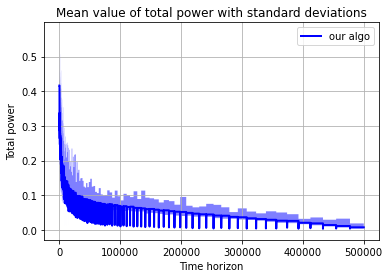

In [7]:

    M = 5

    K = 20

    k = 2
    
    T = 500000

#    T = K*M*1000

#    np.random.seed(30)

#     total_power = np.random.uniform(0.5,1,M*K).reshape(M,K)

#     power = np.random.uniform(0,1,M*k*K).reshape(M,K,k)

#     lam = np.random.uniform(0.5,1,M)
#     lam = lam/np.sum(lam)


#     beta = np.ones((K,k))*0.1

     
    test_times = 50

    result_test_total = np.zeros((T, test_times))
    con_test_total = np.zeros((T, test_times))
    running_time = np.zeros(test_times)
    res_opt_total = np.zeros(test_times)

    result_test_total_acc1 = np.zeros((T, test_times))
    con_test_total_acc1 = np.zeros((T, test_times))
    running_time_acc1 = np.zeros(test_times)
    res_opt_acc1_total = np.zeros(test_times)
    
    result_test_total_acc2 = np.zeros((T, test_times))
    con_test_total_acc2 = np.zeros((T, test_times))
    running_time_acc2 = np.zeros(test_times)
    res_opt_total_acc2 = np.zeros(test_times)


    result_test_total_acc3 = np.zeros((T, test_times))
    con_test_total_acc3 = np.zeros((T, test_times))
    running_time_acc3 = np.zeros(test_times)
    res_opt_total_acc3 = np.zeros(test_times)

    for m in range(test_times):
      #np.random.seed(30)
        total_power = np.random.uniform(0.5,1,M*K).reshape(M,K)
    
        #print("totalpower", total_power)

        power = np.random.uniform(0,1,M*k*K).reshape(M,K,k)
    
        lam = np.random.uniform(0.5,1,M)
        lam = lam/np.sum(lam)

        beta = np.ones((K,k))*0.1
        print("mmmmmmm",m)
#        print(lam)
#         test = VNE(total_power, K, M, T, lam, power, beta)
        
#         start_time = time.time() 

#         res_total, res_opt, con_total = test.run()
        
#         end_time = time.time() 
        
#         running_time[m] = end_time - start_time

#         result_test_total[:,m] = res_total
#         con_test_total[:,m] = con_total

        test_acc1 = VNE(total_power, K, M, T, lam, power, beta)
    
#         test_acc2 = VNE(total_power, K, M, T, lam, power, beta)
        
#         test_acc3 = VNE(total_power, K, M, T, lam, power, beta)
#### acc1       
        start_time = time.time() 

        res_total_acc1, res_opt_acc1, con_total_acc1 = test_acc1.run_acc1()
        
        end_time = time.time() 
        
        running_time_acc1[m] = end_time - start_time
        
        res_opt_acc1_total[m] = res_opt_acc1

        result_test_total_acc1[:,m] = res_total_acc1
        
        con_test_total_acc1[:,m] = con_total_acc1
##### acc2        
#         start_time = time.time() 

#         res_total_acc2, res_opt_acc2, con_total_acc2 = test_acc2.run_acc2()
        
#         end_time = time.time() 
        
#         running_time_acc2[m] = end_time - start_time

#         result_test_total_acc2[:,m] = res_total_acc2
#         con_test_total_acc2[:,m] = con_total_acc2
# # # #####acc3       
#         start_time = time.time() 

#         res_total_acc3, res_opt_acc3, con_total_acc3 = test_acc3.run_acc3()
        
#         end_time = time.time() 
        
#         running_time_acc3[m] = end_time - start_time

#         result_test_total_acc3[:,m] = res_total_acc3

#         con_test_total_acc3[:,m] = con_total_acc3
    
#     data_default = {
#     'max_result': np.max(result_test_total, axis = 1),
#     'min_result': np.min(result_test_total, axis = 1),
#     'mean_result': result_test_total.mean( axis = 1), 
#     'max_con': np.max(con_test_total, axis = 1), 
#     'min_con': np.min(con_test_total, axis = 1),
#     'mean_con': con_test_total.mean(axis =1),
#     'mean_running_time': np.mean(running_time),
#     'max_running_time': np.max(running_time), 
#     'min_running_time': np.min(running_time), 
#     }
#     df = pd.DataFrame(data_default)
#     df.to_csv(f'changed_output_T{T}_{test_times}run_K{K}_M{M}_default.csv', index=False)

#     data_acc1 = {
#     'max_result': np.max(result_test_total_acc1, axis = 1),
#     'min_result': np.min(result_test_total_acc1, axis = 1),
#     'mean_result': result_test_total_acc1.mean( axis = 1),    
#     'mean_running_time': np.mean(running_time_acc1),
#     'max_running_time': np.max(running_time_acc1), 
#     'min_running_time': np.min(running_time_acc1), 
#     'max_opt':np.max(res_opt_acc1_total),
#     'min_opt':np.min(res_opt_acc1_total), 
#     'mean_opt':np.mean(res_opt_acc1_total),
#     }
    data_acc1 = {
    'max_result': np.max(result_test_total_acc1, axis = 1),
    'min_result': np.min(result_test_total_acc1, axis = 1),
    'mean_result': result_test_total_acc1.mean( axis = 1),
    'max_con': np.max(con_test_total_acc1, axis = 1),
    'min_con': np.min(con_test_total_acc1, axis = 1),
    'mean_con': con_test_total_acc1.mean(axis =1),
    'mean_running_time': np.mean(running_time_acc1),
    'max_running_time': np.max(running_time_acc1), 
    'min_running_time': np.min(running_time_acc1), 
    'max_opt':np.max(res_opt_acc1_total),
    'min_opt':np.min(res_opt_acc1_total), 
    'mean_opt':np.mean(res_opt_acc1_total),
    }

    df_acc1 = pd.DataFrame(data_acc1)
    df_acc1.to_csv(f'changed_output_T{T}_{test_times}run_K{K}_M{M}_acc1.csv', index=False)
    
    
#     data_acc2 = {
#     'max_result': np.max(result_test_total_acc2, axis = 1),
#     'min_result': np.min(result_test_total_acc2, axis = 1),
#     'mean_result': result_test_total_acc2.mean( axis = 1), 
#     'max_con': np.max(con_test_total_acc2, axis = 1),
#     'min_con': np.min(con_test_total_acc2, axis = 1),
#     'mean_con': con_test_total_acc2.mean(axis =1),
#     'mean_running_time': np.mean(running_time_acc2),
#     'max_running_time': np.max(running_time_acc2), 
#     'min_running_time': np.min(running_time_acc2), 
#     }

#     df_acc2 = pd.DataFrame(data_acc2)
#     df_acc2.to_csv(f'changed_output_T{T}_{test_times}run_K{K}_M{M}_acc2.csv', index=False)
    
    
#     data_acc3 = {
#     'max_result': np.max(result_test_total_acc3, axis = 1),
#     'min_result': np.min(result_test_total_acc3, axis = 1),
#     'mean_result': result_test_total_acc3.mean( axis = 1),
#     'max_con': np.max(con_test_total_acc3, axis = 1), 
#     'min_con': np.min(con_test_total_acc3, axis = 1),
#     'mean_con': con_test_total_acc3.mean(axis =1),
#     'mean_running_time': np.mean(running_time_acc3),
#     'max_running_time': np.max(running_time_acc3), 
#     'min_running_time': np.min(running_time_acc3), 
#     }

#     df_acc3 = pd.DataFrame(data_acc3)
#     df_acc3.to_csv(f'changed_output_T{T}_{test_times}run_K{K}_M{M}_acc3.csv', index=False)
# #Save the DataFrame to a CSV file


    #plt.savefig("test_K50M20.pdf", format="pdf", bbox_inches="tight")


    
#     x = np.arange(T)

#     y = result_test_total.mean(axis=1) # Effectively y = x**2

#     e = np.std(result_test_total, axis=1)

#     fig, ax = plt.subplots(1)

#     ax.plot(x, y, lw=2, label='our algo', color='blue')

#     ax.plot(x, res_opt_acc1.repeat(T), lw=2, label='opt', color='red')

#     #ax.fill_between(x, y+e, y-e, facecolor='blue', alpha=0.5)

#     ax.set_title('Mean value of total power with standard deviations')

#     ax.legend(loc='upper left')

#     ax.set_xlabel('Time horizon')

#     ax.set_ylabel('Total power')

#     ax.grid()
    
        
#     x = np.arange(T)

#     y = np.max(con_test_total_acc1,axis=1) # Effectively y = x**2

#     #e = np.std(result_test_total_acc1, axis=1)

#     fig, ax = plt.subplots(1)

#     ax.plot(x, y, lw=2, label='our algo', color='blue')

#     #ax.plot(x, np.mean(res_opt_acc1_total).repeat(T), lw=2, label='opt', color='red')

#     #ax.fill_between(x, y+e, y-e, facecolor='blue', alpha=0.5)
#     ax.set_title('Mean value of total power with standard deviations')
#     ax.set_ylim([0,1.1])
#     ax.legend(loc='upper left')

#     ax.set_xlabel('Time horizon')

#     ax.set_ylabel('Total power')
#    plt.savefig("test_K200M40.pdf", format="pdf", bbox_inches="tight")
#     ax.grid()

    x = np.arange(T)

    y = result_test_total_acc1.mean(axis=1) # Effectively y = x**2

    e = np.std(result_test_total_acc1, axis=1)

    fig, ax = plt.subplots(1)

    ax.plot(x, y, lw=2, label='our algo', color='blue')

    #ax.plot(x, np.array(1).repeat(T), lw=2, label='opt', color='red')

    ax.fill_between(x, np.max(result_test_total_acc1, axis = 1), np.min(result_test_total_acc1, axis = 1), facecolor='blue', alpha=0.5)

    ax.set_title('Mean value of total power with standard deviations')

    ax.legend(loc='upper right')

    ax.set_xlabel('Time horizon')

    ax.set_ylabel('Total power')

    ax.grid() 
    
    
        
#     x = np.arange(T)

#     y = result_test_total_acc2.mean(axis=1) # Effectively y = x**2

#     e = np.std(result_test_total_acc2, axis=1)

#     fig, ax = plt.subplots(1)

#     ax.plot(x, y, lw=2, label='our algo', color='blue')

#     #ax.plot(x, res_opt_acc2.repeat(T), lw=2, label='opt', color='red')

#     ax.fill_between(x, y+e, y-e, facecolor='blue', alpha=0.5)

#     ax.set_title('Mean value of total power with standard deviations')

#     ax.legend(loc='upper left')

#     ax.set_xlabel('Time horizon')

#     ax.set_ylabel('Total power')

#     ax.grid()
    
        
#     x = np.arange(T)

#     y = result_test_total_acc3.mean(axis=1) # Effectively y = x**2

#     e = np.std(result_test_total_acc3, axis=1)

#     fig, ax = plt.subplots(1)

#     ax.plot(x, y, lw=2, label='our algo', color='blue')

#     #ax.plot(x, res_opt_acc3.repeat(T), lw=2, label='opt', color='red')

#     ax.fill_between(x, y+e, y-e, facecolor='blue', alpha=0.5)

#     ax.set_title('Mean value of total power with standard deviations')

#     ax.legend(loc='upper left')

#     ax.set_xlabel('Time horizon')

#     ax.set_ylabel('Total power')

#     ax.grid()

In [259]:
print(test_acc1.beta_new)
print(test_acc1.kl_power)
print(test_acc1.kl_lam_up)
# print(test_acc1.getLCBKL(0.6,60,0,1,tol = 1e-7))
# print(test_acc1.total_power_hat[9,49])
print(test_acc1.pulls)
# print(test_acc1.kl_total_power[9,49])
# print(test_acc1.total_power_cumu[9,49])

[[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1. 1.

In [66]:
##test:

M = 10

K = 50

k = 2

T = 100000
test_acc1 = VNE(total_power, K, M, T, lam, power, beta)
print(test_acc1.getLCBKL(0.54,60,0,1,tol = 1e-7))

[  501.   502.   503.   504.   505.   506.   507.   508.   509.   510.
   511.   512.   513.   514.   515.   516.   517.   518.   519.   520.
   521.   522.   523.   524.   525.   526.   528.   529.   530.   532.
   534.   535.   537.   539.   541.   543.   545.   547.   550.   552.
   555.   557.   560.   563.   566.   570.   573.   577.   581.   585.
   589.   593.   598.   603.   608.   614.   619.   625.   632.   638.
   645.   652.   660.   668.   676.   685.   694.   704.   714.   725.
   736.   748.   760.   773.   787.   801.   816.   832.   849.   866.
   885.   904.   924.   945.   968.   991.  1016.  1041.  1068.  1097.
  1127.  1158.  1191.  1225.  1262.  1300.  1340.  1382.  1426.  1472.
  1521.  1572.  1625.  1682.  1741.  1803.  1868.  1936.  2008.  2083.
  2163.  2246.  2333.  2425.  2521.  2622.  2728.  2839.  2956.  3079.
  3208.  3344.  3486.  3635.  3792.  3956.  4129.  4311.  4501.  4701.
  4911.  5132.  5363.  5607.  5862.  6130.  6411.  6707.  7017.  7343.
  7685

In [142]:
print(res_opt_acc1)

0.5082068564322436


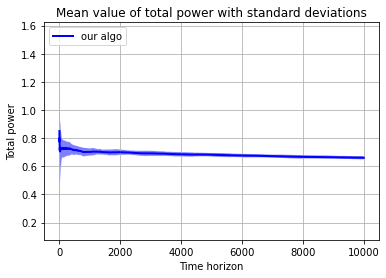

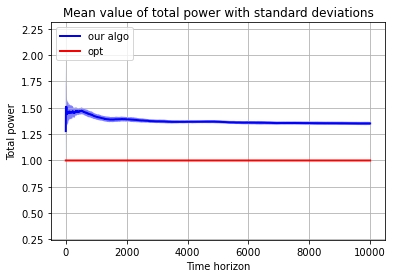

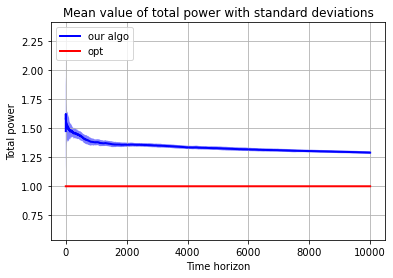

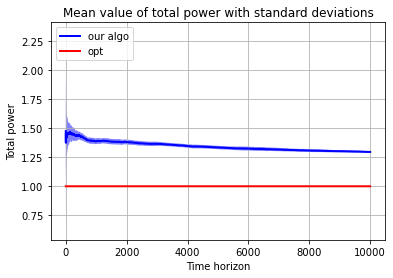

In [150]:
    x = np.arange(T)

    y = (result_test_total).mean(axis=1)*res_opt_acc1# Effectively y = x**2

    e = np.std(result_test_total, axis=1)

    fig, ax = plt.subplots(1)

    ax.plot(x, y, lw=2, label='our algo', color='blue')

    #ax.plot(x, np.array(res_opt_acc1).repeat(T)), lw=2, label='opt', color='red')

    ax.fill_between(x, y+e, y-e, facecolor='blue', alpha=0.5)

    ax.set_title('Mean value of total power with standard deviations')

    ax.legend(loc='upper left')

    ax.set_xlabel('Time horizon')

    ax.set_ylabel('Total power')

    ax.grid()
    #plt.savefig("test_K50M10_seed_3_default.pdf", format="pdf", bbox_inches="tight")
    
    
    x = np.arange(T)

    y = result_test_total_acc1.mean(axis=1) # Effectively y = x**2

    e = np.std(result_test_total_acc1, axis=1)

    fig, ax = plt.subplots(1)

    ax.plot(x, y, lw=2, label='our algo', color='blue')

    ax.plot(x, np.array(1).repeat(T), lw=2, label='opt', color='red')

    ax.fill_between(x, y+e, y-e, facecolor='blue', alpha=0.5)

    ax.set_title('Mean value of total power with standard deviations')

    ax.legend(loc='upper left')

    ax.set_xlabel('Time horizon')

    ax.set_ylabel('Total power')

    ax.grid() 
    #plt.savefig("test_K50M10_seed_3_acc1.pdf", format="pdf", bbox_inches="tight")
    
    
        
    x = np.arange(T)

    y = result_test_total_acc2.mean(axis=1) # Effectively y = x**2

    e = np.std(result_test_total_acc2, axis=1)

    fig, ax = plt.subplots(1)

    ax.plot(x, y, lw=2, label='our algo', color='blue')

    ax.plot(x, np.array(1).repeat(T), lw=2, label='opt', color='red')

    ax.fill_between(x, y+e, y-e, facecolor='blue', alpha=0.5)

    ax.set_title('Mean value of total power with standard deviations')

    ax.legend(loc='upper left')

    ax.set_xlabel('Time horizon')

    ax.set_ylabel('Total power')

    ax.grid()
    #plt.savefig("test_K50M10_seed_3_acc2.pdf", format="pdf", bbox_inches="tight")
    
        
    x = np.arange(T)

    y = result_test_total_acc3.mean(axis=1) # Effectively y = x**2

    e = np.std(result_test_total_acc3, axis=1)

    fig, ax = plt.subplots(1)

    ax.plot(x, y, lw=2, label='our algo', color='blue')

    ax.plot(x, np.array(1).repeat(T), lw=2, label='opt', color='red')

    ax.fill_between(x, y+e, y-e, facecolor='blue', alpha=0.5)

    ax.set_title('Mean value of total power with standard deviations')

    ax.legend(loc = 'upper left')

    ax.set_xlabel('Time horizon')

    ax.set_ylabel('Total power')

    ax.grid()
    #plt.savefig("test_K50M10_seed_3_acc3.pdf", format="pdf", bbox_inches="tight")


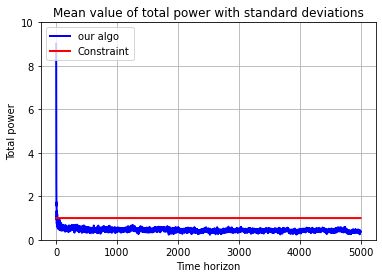

In [133]:
    x = np.arange(T)

    y =  np.mean(con_test_total_acc3,axis=1)  # Effectively y = x**2

    #e = np.std(result_test_total_acc1, axis=1)

    fig, ax = plt.subplots(1)

    ax.plot(x, y, lw=2, label='our algo', color='blue')

    ax.plot(x, np.array(1).repeat(T), lw=2, label='Constraint', color='red')

    #ax.fill_between(x, y+e, y-e, facecolor='blue', alpha=0.5)
    ax.set_title('Mean value of total power with standard deviations')
    ax.set_ylim([0,10])
    ax.legend(loc='upper left')

    ax.set_xlabel('Time horizon')

    ax.set_ylabel('Total power')
    ax.grid()
    plt.savefig("test_K50M10_constraint_acc3.pdf", format="pdf", bbox_inches="tight")


In [134]:
    data_default = {
    'max_result': np.max(result_test_total, axis = 1),
    'min_result': np.min(result_test_total, axis = 1),
    'mean_result': result_test_total.mean( axis = 1), 
    'max_con': np.max(con_test_total, axis = 1), 
    'mean_running_time': np.mean(running_time),
    'max_running_time': np.max(running_time), 
    'min_running_time': np.min(running_time), 
    }
    df = pd.DataFrame(data_default)
    df.to_csv('output_T5000_20run_K50_M10_default_1.csv', index=False)

#     data_acc1 = {
#     'max_result': np.max(result_test_total_acc1, axis = 1),
#     'min_result': np.min(result_test_total_acc1, axis = 1),
#     'mean_result': result_test_total_acc1.mean( axis = 1),    
#     'mean_running_time': np.mean(running_time_acc1),
#     'max_running_time': np.max(running_time_acc1), 
#     'min_running_time': np.min(running_time_acc1), 
#     'max_opt':np.max(res_opt_acc1_total),
#     'min_opt':np.min(res_opt_acc1_total), 
#     'mean_opt':np.mean(res_opt_acc1_total),
#     }
    data_acc1 = {
    'max_result': np.max(result_test_total_acc1, axis = 1),
    'min_result': np.min(result_test_total_acc1, axis = 1),
    'mean_result': result_test_total_acc1.mean( axis = 1),
    'max_con': np.max(con_test_total_acc1, axis = 1), 
    'mean_running_time': np.mean(running_time_acc1),
    'max_running_time': np.max(running_time_acc1), 
    'min_running_time': np.min(running_time_acc1), 
    'max_opt':np.max(res_opt_acc1_total),
    'min_opt':np.min(res_opt_acc1_total), 
    'mean_opt':np.mean(res_opt_acc1_total),
    }

    df_acc1 = pd.DataFrame(data_acc1)
    df_acc1.to_csv('output_T5000_20run_K50_M10_acc1_1.csv', index=False)
    
    
    data_acc2 = {
    'max_result': np.max(result_test_total_acc2, axis = 1),
    'min_result': np.min(result_test_total_acc2, axis = 1),
    'mean_result': result_test_total_acc2.mean( axis = 1), 
    'max_con': np.max(con_test_total_acc2, axis = 1), 
    'mean_running_time': np.mean(running_time_acc2),
    'max_running_time': np.max(running_time_acc2), 
    'min_running_time': np.min(running_time_acc2), 
    }

    df_acc2 = pd.DataFrame(data_acc2)
    df_acc2.to_csv('output_T5000_20run_K50_M10_acc2_1.csv', index=False)
    
    
    data_acc3 = {
    'max_result': np.max(result_test_total_acc3, axis = 1),
    'min_result': np.min(result_test_total_acc3, axis = 1),
    'mean_result': result_test_total_acc3.mean( axis = 1),
    'max_con': np.max(con_test_total_acc3, axis = 1), 
    'mean_running_time': np.mean(running_time_acc3),
    'max_running_time': np.max(running_time_acc3), 
    'min_running_time': np.min(running_time_acc3), 
    }

    df_acc3 = pd.DataFrame(data_acc3)
    df_acc3.to_csv('output_T5000_20run_K50_M10_acc3_1.csv', index=False)

mmmmmmm 0
[  51.   52.   53.   54.   55.   56.   57.   58.   59.   61.   62.   64.
   66.   69.   72.   75.   79.   83.   88.   94.  100.  108.  116.  126.
  138.  151.  166.  183.  203.  226.  253.  283.  318.  358.  404.  457.
  518.  589.  670.  763.  869.  992. 1134. 1296. 1483. 1698. 1945. 2230.
 2557. 2933. 3365. 3862. 4434.]
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 1
iterations 2
iterations 3
iterations 4
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
ite

/tmp/ipykernel_7149/3868012973.py:341: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  arm_chosen[player] = np.random.choice(self.K, 1, p = nor_strategy[player,:])
/tmp/ipykernel_7149/3868012973.py:332: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  arm_chosen[player] = np.random.choice(self.K, 1, p = nor_strategy[player,:])


iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 1
iterations 2
iterations 3
iterations 4
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 1
iterations 2
iterations 3
iterations 4
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 1
iterations 2

/tmp/ipykernel_7149/3868012973.py:352: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  arm_chosen[player] = np.random.choice(self.K, 1, p = nor_strategy[player,:])


iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 1
iterations 2
iterations 3
iterations 4
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 1
iterations 2
iterations 3
iterations 4
iterations 1
iterations 2
iterations 3

iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 1
iterations 2

iterations 3
iterations 4
iterations 5
iterations 6
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 7
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 7
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 7
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5

iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 7
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 7
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 7
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 7
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 7
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 7
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 7
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 7
iterations 1
iterations 2
iterations 3
iterations 4
iterations 5
iterations 6
iterations 7
iterations 1
iterations 2
iterations 3

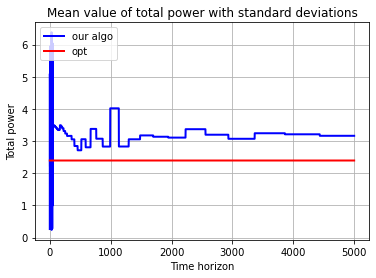

In [518]:
# import cProfile
# cProfile.run('toto()')
toto()

In [464]:
print(np.arange(np.ceil(np.log(5000)/np.log(1.5))))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21.]


29500


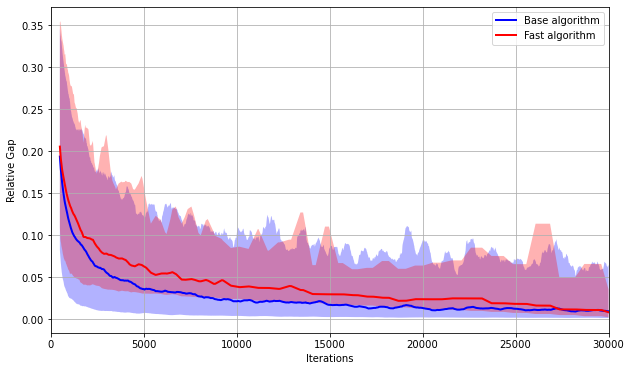

In [10]:
T = 30000
win = 500
# df_default = pd.read_csv('final_output_T500000_50run_K10_M3_acc1.csv')
# df_acc1 = pd.read_csv('final_output_T500000_50run_K20_M5_acc1.csv')
# df_acc2 = pd.read_csv('final_output_T500000_50run_K50_M8_acc1.csv')
# df_acc3 = pd.read_csv('final_output_T500000_50run_K100_M10_acc1.csv')
df_default = pd.read_csv('changed_output_T30000_50run_K10_M3_default.csv')
#sub_samples = np.round(np.linspace(1, len(T), num=100)).astype(int) 
df_acc1 = pd.read_csv('changed_output_T30000_50run_K10_M3_acc1.csv')
df_acc2 = pd.read_csv('changed_output_T30000_50run_K10_M3_acc2.csv')
df_acc3 = pd.read_csv('changed_output_T30000_50run_K10_M3_acc3.csv')
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(T)
r = range(win,T)
# Plot max_result
#y = np.convolve( df_default['mean_result'],np.ones(win))/win
#y = y[r]
y = filtering(df_default['mean_result'],win)
y1 = filtering(df_acc1['mean_result'],win)
y2 = filtering(df_acc2['mean_result'],win)
y3 = filtering(df_acc3['mean_result'],win)
# y1 = np.convolve( df_acc1['mean_result'],np.ones(win))/win
# y2 = np.convolve( df_acc2['mean_result'],np.ones(win))/win
# y3 = np.convolve( df_acc3['mean_result'],np.ones(win))/win
# y1 = y1[r]
# y2 = y2[r]
# y3 = y3[r]
print(len(y1))
# y1 = df_acc1['mean_result']
# y2 = df_acc2['mean_result']
# y3 = df_acc3['mean_result']

# y = df_default['max_con']
# y1 = df_acc1['max_con']
# y2 = df_acc2['max_con']
# y3 = df_acc3['max_con']

ax.plot(x[r], y, lw=2, label='Base algorithm', color='blue')
ax.fill_between(x[r], (np.convolve( df_default['max_result'],np.ones(win))/win)[r], (np.convolve( df_default['min_result'],np.ones(win))/win)[r], facecolor='blue', alpha=0.3)
ax.plot(x[r], y1, lw=2, label='Fast algorithm', color='red')
ax.fill_between(x[r], (np.convolve( df_acc1['max_result'],np.ones(win))/win)[r], (np.convolve( df_acc1['min_result'],np.ones(win))/win)[r], facecolor='red', alpha=0.3)
#ax.plot(x[r], y2, lw=2, label='Algo_acc2', color='green')
#ax.plot(x, np.array(1).repeat(T), lw=2, label='Constraints Limits', color='black')
#ax.fill_between(x[r], (np.convolve( df_acc2['max_result'],np.ones(win))/win)[r], (np.convolve( df_acc2['min_result'],np.ones(win))/win)[r], facecolor='green', alpha=0.3)
#ax.plot(x[r], y3, lw=2, label='Algo_acc3', color='black')
#ax.fill_between(x[r], (np.convolve( df_acc3['max_result'],np.ones(win))/win)[r], (np.convolve( df_acc3['min_result'],np.ones(win))/win)[r], facecolor='black', alpha=0.1)
#ax.set_title('XXXX')
ax.legend(loc='upper right')
ax.set_xlabel('Iterations')
ax.set_ylabel('Relative Gap')
#ax.set_ylim([0.5,1.5])
ax.set_xlim([0,T])
ax.grid()
plt.savefig("test_T30000_algos_sub_changed_final.pdf", format="pdf", bbox_inches="tight")


29500


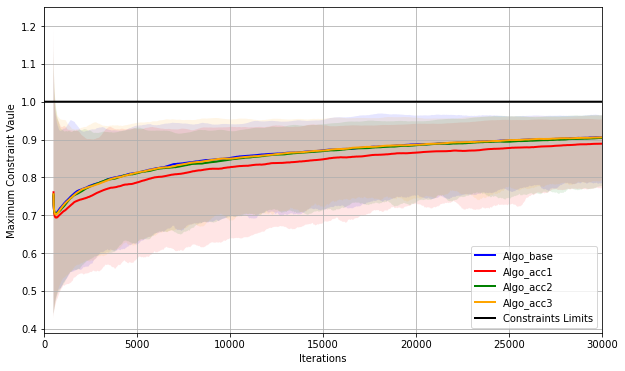

In [60]:
T = 30000
win = 500
# df_default = pd.read_csv('final_output_T500000_50run_K10_M3_acc1.csv')
# df_acc1 = pd.read_csv('final_output_T500000_50run_K20_M5_acc1.csv')
# df_acc2 = pd.read_csv('final_output_T500000_50run_K50_M8_acc1.csv')
# df_acc3 = pd.read_csv('final_output_T500000_50run_K100_M10_acc1.csv')
df_default = pd.read_csv('changed_output_T30000_50run_K10_M3_default.csv')
#sub_samples = np.round(np.linspace(1, len(T), num=100)).astype(int) 
df_acc1 = pd.read_csv('changed_output_T30000_50run_K10_M3_acc1.csv')
df_acc2 = pd.read_csv('changed_output_T30000_50run_K10_M3_acc2.csv')
df_acc3 = pd.read_csv('changed_output_T30000_50run_K10_M3_acc3.csv')
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(T)
r = range(win,T)
# Plot max_result
#y = np.convolve( df_default['mean_result'],np.ones(win))/win
#y = y[r]
y = filtering(df_default['mean_con'],win)
y1 = filtering(df_acc1['mean_con'],win)
y2 = filtering(df_acc2['mean_con'],win)
y3 = filtering(df_acc3['mean_con'],win)
# y1 = np.convolve( df_acc1['mean_result'],np.ones(win))/win
# y2 = np.convolve( df_acc2['mean_result'],np.ones(win))/win
# y3 = np.convolve( df_acc3['mean_result'],np.ones(win))/win
# y1 = y1[r]
# y2 = y2[r]
# y3 = y3[r]
print(len(y1))
# y1 = df_acc1['mean_result']
# y2 = df_acc2['mean_result']
# y3 = df_acc3['mean_result']

# y = df_default['max_con']
# y1 = df_acc1['max_con']
# y2 = df_acc2['max_con']
# y3 = df_acc3['max_con']

ax.plot(x[r], y, lw=2, label='Algo_base', color='blue')
ax.fill_between(x[r], (np.convolve( df_default['max_con'],np.ones(win))/win)[r], (np.convolve( df_default['min_con'],np.ones(win))/win)[r], facecolor='blue', alpha=0.1)
ax.plot(x[r], y1, lw=2, label='Algo_acc1', color='red')
ax.fill_between(x[r], (np.convolve( df_acc1['max_con'],np.ones(win))/win)[r], (np.convolve( df_acc1['min_con'],np.ones(win))/win)[r], facecolor='red', alpha=0.1)
ax.plot(x[r], y2, lw=2, label='Algo_acc2', color='green')
ax.fill_between(x[r], (np.convolve( df_acc2['max_con'],np.ones(win))/win)[r], (np.convolve( df_acc2['min_con'],np.ones(win))/win)[r], facecolor='green', alpha=0.1)
ax.plot(x[r], y3, lw=2, label='Algo_acc3', color='orange')
ax.fill_between(x[r], (np.convolve( df_acc3['max_con'],np.ones(win))/win)[r], (np.convolve( df_acc3['min_con'],np.ones(win))/win)[r], facecolor='orange', alpha=0.1)
#ax.set_title('XXXX')
ax.plot(x, np.array(1).repeat(T), lw=2, label='Constraints Limits', color='black')
ax.legend(loc='lower right')
ax.set_xlabel('Iterations')
ax.set_ylabel('Maximum Constraint Vaule')
ax.set_xlim([0,T])
ax.grid()
plt.savefig("test_T30000_algos_sub_constraint_changed.pdf", format="pdf", bbox_inches="tight")


In [ ]:
T = 500000
win = 15000
df_default = pd.read_csv('final_output_T500000_50run_K10_M3_acc1.csv')
df_acc1 = pd.read_csv('final_output_T500000_50run_K20_M5_acc1.csv')
df_acc2 = pd.read_csv('final_output_T500000_50run_K50_M8_acc1.csv')
df_acc3 = pd.read_csv('final_output_T500000_50run_K100_M10_acc1.csv')
# df_default = pd.read_csv('final_output_T30000_50run_K10_M3_default_30.csv')
#sub_samples = np.round(np.linspace(1, len(T), num=100)).astype(int) 
# df_acc1 = pd.read_csv('final_output_T30000_50run_K10_M3_acc1_30.csv')
# df_acc2 = pd.read_csv('final_output_T30000_50run_K10_M3_acc2_30.csv')
# df_acc3 = pd.read_csv('final_output_T30000_50run_K10_M3_acc3_30.csv')
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(T)
r = range(win,T)
# Plot max_result
#y = np.convolve( df_default['mean_result'],np.ones(win))/win
#y = y[r]
y = filtering(df_default['mean_result'],win)
y1 = filtering(df_acc1['mean_result'],win)
y2 = filtering(df_acc2['mean_result'],win)
y3 = filtering(df_acc3['mean_result'],win)
# y1 = np.convolve( df_acc1['mean_result'],np.ones(win))/win
# y2 = np.convolve( df_acc2['mean_result'],np.ones(win))/win
# y3 = np.convolve( df_acc3['mean_result'],np.ones(win))/win
# y1 = y1[r]
# y2 = y2[r]
# y3 = y3[r]
print(len(y1))
# y1 = df_acc1['mean_result']
# y2 = df_acc2['mean_result']
# y3 = df_acc3['mean_result']

# y = df_default['max_con']
# y1 = df_acc1['max_con']
# y2 = df_acc2['max_con']
# y3 = df_acc3['max_con']

ax.plot(x[r], y, lw=2, label='K=10,M=3', color='blue')
ax.fill_between(x[r], (np.convolve( df_default['max_result'],np.ones(win))/win)[r], (np.convolve( df_default['min_result'],np.ones(win))/win)[r], facecolor='blue', alpha=0.3)
ax.plot(x[r], y1, lw=2, label='K=20,M=5', color='red')
ax.fill_between(x[r], (np.convolve( df_acc1['max_result'],np.ones(win))/win)[r], (np.convolve( df_acc1['min_result'],np.ones(win))/win)[r], facecolor='red', alpha=0.3)
ax.plot(x[r], y2, lw=2, label='K=50,M=8', color='green')
#ax.plot(x, np.array(1).repeat(T), lw=2, label='Constraints Limits', color='black')
ax.fill_between(x[r], (np.convolve( df_acc2['max_result'],np.ones(win))/win)[r], (np.convolve( df_acc2['min_result'],np.ones(win))/win)[r], facecolor='green', alpha=0.3)
ax.plot(x[r], y3, lw=2, label='K=100,M=10', color='black')
ax.fill_between(x[r], (np.convolve( df_acc3['max_result'],np.ones(win))/win)[r], (np.convolve( df_acc3['min_result'],np.ones(win))/win)[r], facecolor='black', alpha=0.1)
#ax.set_title('XXXX')
ax.legend(loc='upper right')
ax.set_xlabel('Iterations')
ax.set_ylabel('Relative Gap')
#ax.set_ylim([0.5,1.5])
ax.set_xlim([0,T])
ax.grid()
plt.savefig("test_T500000_algos_sub_diff.pdf", format="pdf", bbox_inches="tight")


In [ ]:
T = 500000
win = 10000
df_default = pd.read_csv('final_output_T500000_50run_K10_M3_acc1.csv')
df_acc1 = pd.read_csv('final_output_T500000_50run_K20_M5_acc1.csv')
df_acc2 = pd.read_csv('final_output_T500000_50run_K50_M8_acc1.csv')
df_acc3 = pd.read_csv('final_output_T500000_50run_K100_M10_acc1.csv')
# df_default = pd.read_csv('final_output_T30000_50run_K10_M3_default_30.csv')
# #sub_samples = np.round(np.linspace(1, len(T), num=100)).astype(int) 
# df_acc1 = pd.read_csv('final_output_T30000_50run_K10_M3_acc1_30.csv')
# df_acc2 = pd.read_csv('final_output_T30000_50run_K10_M3_acc2_30.csv')
# df_acc3 = pd.read_csv('final_output_T30000_50run_K10_M3_acc3_30.csv')
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(T)
r = range(win,T)
# Plot max_result
#y = np.convolve( df_default['mean_result'],np.ones(win))/win
#y = y[r]
y = filtering(df_default['mean_con'],win)
y1 = filtering(df_acc1['mean_con'],win)
y2 = filtering(df_acc2['mean_con'],win)
y3 = filtering(df_acc3['mean_con'],win)
# y1 = np.convolve( df_acc1['mean_result'],np.ones(win))/win
# y2 = np.convolve( df_acc2['mean_result'],np.ones(win))/win
# y3 = np.convolve( df_acc3['mean_result'],np.ones(win))/win
# y1 = y1[r]
# y2 = y2[r]
# y3 = y3[r]
print(len(y1))
# y1 = df_acc1['mean_result']
# y2 = df_acc2['mean_result']
# y3 = df_acc3['mean_result']

# y = df_default['max_con']
# y1 = df_acc1['max_con']
# y2 = df_acc2['max_con']
# y3 = df_acc3['max_con']

ax.plot(x[r], y, lw=2, label='K=20,M=5', color='blue')
ax.fill_between(x[r], (np.convolve( df_default['max_con'],np.ones(win))/win)[r], (np.convolve( df_default['min_con'],np.ones(win))/win)[r], facecolor='blue', alpha=0.1)
ax.plot(x[r], y1, lw=2, label='K=50,M=8', color='red')
ax.fill_between(x[r], (np.convolve( df_acc1['max_con'],np.ones(win))/win)[r], (np.convolve( df_acc1['min_con'],np.ones(win))/win)[r], facecolor='red', alpha=0.1)
ax.plot(x[r], y2, lw=2, label='K=100,M=10', color='green')

ax.fill_between(x[r], (np.convolve( df_acc2['max_con'],np.ones(win))/win)[r], (np.convolve( df_acc2['min_con'],np.ones(win))/win)[r], facecolor='green', alpha=0.1)
ax.plot(x[r], y3, lw=2, label='Algo_acc3', color='orange')
ax.fill_between(x[r], (np.convolve( df_acc3['max_con'],np.ones(win))/win)[r], (np.convolve( df_acc3['min_con'],np.ones(win))/win)[r], facecolor='orange', alpha=0.3)
#ax.set_title('XXXX')
ax.plot(x, np.array(1).repeat(T), lw=2, label='Constraints Limits', color='black')
ax.legend(loc='center right')
ax.set_xlabel('Iterations')
ax.set_ylabel('Maximum Constraint Vaule')
ax.set_xlim([0,500000])
ax.grid()
plt.savefig("test_T500000_algos_sub_constraint_final.pdf", format="pdf", bbox_inches="tight")


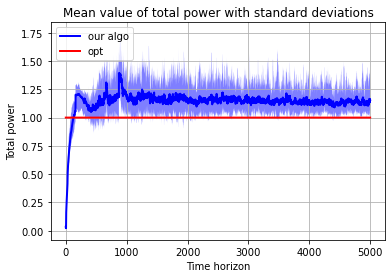

In [191]:

    df_acc3 = pd.read_csv('output_T5000_20run_K50_M10_acc3.csv')
    
    y = df_acc3['mean_result']
    
    x = np.arange(5000)

    y1 = df_acc3['max_result'] 
    
    y2 = df_acc3['min_result']

    fig, ax = plt.subplots(1)

    ax.plot(x, y, lw=2, label='our algo', color='blue')

    ax.plot(x, np.array(1).repeat(5000), lw=2, label='opt', color='red')

    ax.fill_between(x, y1, y2, facecolor='blue', alpha=0.5)

    ax.set_title('Mean value of total power with standard deviations')

    ax.legend(loc='upper left')

    ax.set_xlabel('Time horizon')

    ax.set_ylabel('Total power')

    ax.grid()
    plt.savefig("test_K50M10_seed_3_acc3.pdf", format="pdf", bbox_inches="tight")
    

In [ ]:
    x = np.arange(T)

    y = np.max(con_test_total_acc1,axis=1) # Effectively y = x**2

    #e = np.std(result_test_total_acc1, axis=1)

    fig, ax = plt.subplots(1)

    ax.plot(x, y, lw=2, label='our algo', color='blue')

    #ax.plot(x, np.mean(res_opt_acc1_total).repeat(T), lw=2, label='opt', color='red')

    #ax.fill_between(x, y+e, y-e, facecolor='blue', alpha=0.5)
    ax.set_title('Mean value of total power with standard deviations')
    ax.set_ylim([0,1.1])
    ax.legend(loc='upper left')

    ax.set_xlabel('Time horizon')

    ax.set_ylabel('Total power')

In [9]:
def filtering(y,win):
    z = np.convolve(y,np.ones(win))/win
    return z[range(win,len(y))]